In [3]:
import numpy as np
import matplotlib.pyplot as plt

from auxiliary import values as v
from auxiliary.utils.colors import bcolors as c
from auxiliary.data import imaging

from feature_extraction.feature_extractor import filter_by_margin, filter_by_volume

MEMBRANES

In [7]:
masks = imaging.read_tiff(
    v.data_path + 'Gr7/RawImages/Membrane/PreProcessing/confocal_3D_unet_sa_meristem_cells/GASP/PostProcessing/20190403_E2_mGFP_decon_0.5_predictions_gasp_average.tiff',
    axes='ZYX',
    verbose=1
)
print(masks.shape)

Reading TIFF: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr7/RawImages/Membrane/PreProcessing/confocal_3D_unet_sa_meristem_cells/GASP/PostProcessing/20190403_E2_mGFP_decon_0.5_predictions_gasp_average.tiff
(1024, 1024, 490)


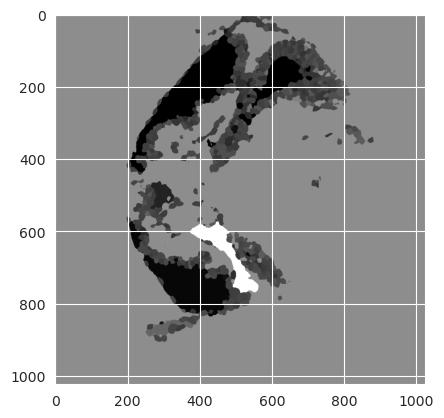

In [8]:
plt.imshow(masks[..., 100], cmap='gray')

In [9]:
masks = filter_by_volume(masks[..., 100:150], verbose=1)

Filtering by volume...
	Found 2546  cells
	Removing 91 cells...



Saving prediction: mask_test.tiff


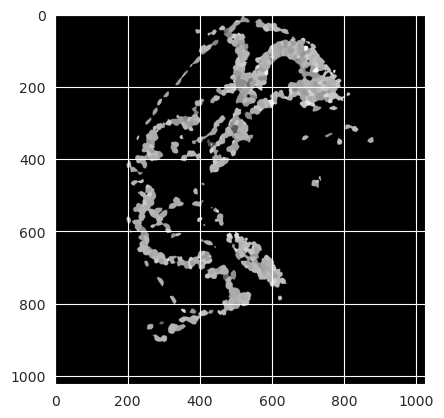

In [11]:
plt.imshow(masks[..., 0], cmap='gray')
imaging.save_prediction(masks, 'mask_test.tiff', verbose=1)

In [14]:
img_path = v.data_path + 'Gr1/Segmentation/Nuclei/20190208_E2_mask_PLACEHOLDER.nii.gz'
img = imaging.read_image(img_path, axes='ZYX', verbose=1)

Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/Segmentation/Nuclei/20190208_E2_mask_PLACEHOLDER.nii.gz


PSEUDO LABELS

In [10]:
import pandas as pd
import os
import sys 

from cell_division.nets.transfer_learning import CNN
from cell_division.semi_supervised import pseudo_labeling

from auxiliary.data.dataset_cell import CellDataset
from auxiliary.data.dataset_unlabeled import UnlabeledDataset
from auxiliary.utils import visualizer as vis

from sklearn.metrics import classification_report, confusion_matrix

In [12]:
img_dir = v.data_path + 'CellDivision/images_nuclei/'
img_dir_unlabeled = v.data_path + 'CellDivision/images_unlabeled/'

label_train_dir = v.data_path + 'CellDivision/undersampled/train.csv'
label_test_dir = v.data_path + 'CellDivision/undersampled/test.csv'
label_val_dir = v.data_path + 'CellDivision/undersampled/val.csv'

INPUT_SHAPE = (100, 100, 3)
BATCH_SIZE = 16

In [24]:
train_generator = CellDataset(
    img_dir, 
    label_train_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

val_generator = CellDataset(
    img_dir, 
    label_val_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

test_generator = CellDataset(
    img_dir, 
    label_test_dir,
    batch_size=BATCH_SIZE,
    resize=INPUT_SHAPE[:2]
)

unlabeled_generator = UnlabeledDataset(
    img_dir_unlabeled,
    batch_size=1,
    resize=INPUT_SHAPE[:2]
)

In [15]:
model_semi = CNN()
model_semi.load('../models/cellular_division_models/vgg16_semi.h5')
# model.load('../models/cellular_division_models/vgg16_nuclei_under.h5')

8/8 [==============================] - 3s 386ms/step - loss: 0.6249 - auc: 0.9461
                    precision    recall  f1-score   support

Prophase/Metaphase       0.75      0.95      0.84        42
Anaphase/Telophase       0.88      0.71      0.79        42
        Interphase       0.93      0.86      0.89        43

          accuracy                           0.84       127
         macro avg       0.85      0.84      0.84       127
      weighted avg       0.85      0.84      0.84       127



<Figure size 1200x1200 with 0 Axes>

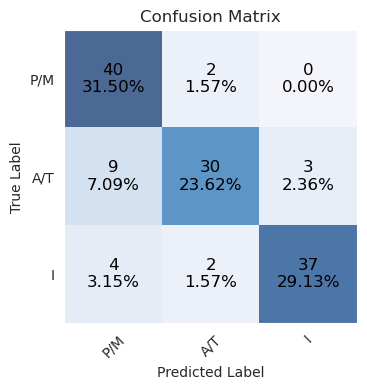

In [16]:
model_semi.model.evaluate(train_generator)
model_semi.model.evaluate(val_generator)
model_semi.model.evaluate(test_generator)

pred = model_semi.model.predict(test_generator).round().astype(int)

print(
    classification_report(
        test_generator.img_labels, [test_generator.oh2class(p) for p in pred], 
        target_names=test_generator.CLASS_NAMES,
        zero_division=0
    )
)

cf_matrix = confusion_matrix(
   test_generator.img_labels, [test_generator.oh2class(p) for p in pred]
)

plt.figure(figsize=(12, 12))
vis.plot_confusion_matrix(cf_matrix)

In [17]:
model_nuclei = CNN()
# model_nuclei.load('../models/cellular_division_models/vgg16_semi.h5')
model_nuclei.load('../models/cellular_division_models/vgg16_nuclei_under.h5')

8/8 [==============================] - 3s 410ms/step - loss: 0.6814 - auc: 0.9435
                    precision    recall  f1-score   support

Prophase/Metaphase       0.89      0.81      0.85        42
Anaphase/Telophase       0.82      0.86      0.84        42
        Interphase       0.87      0.91      0.89        43

          accuracy                           0.86       127
         macro avg       0.86      0.86      0.86       127
      weighted avg       0.86      0.86      0.86       127



<Figure size 1200x1200 with 0 Axes>

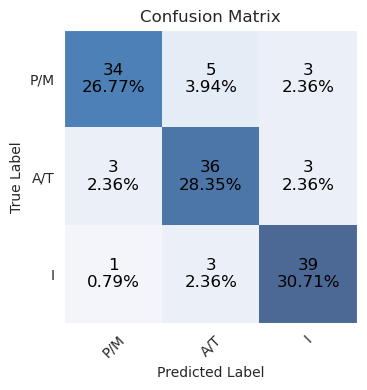

In [18]:
model_nuclei.model.evaluate(train_generator)
model_nuclei.model.evaluate(val_generator)
model_nuclei.model.evaluate(test_generator)

pred = model_nuclei.model.predict(test_generator).round().astype(int)

print(
    classification_report(
        test_generator.img_labels, [test_generator.oh2class(p) for p in pred], 
        target_names=test_generator.CLASS_NAMES,
        zero_division=0
    )
)

cf_matrix = confusion_matrix(
   test_generator.img_labels, [test_generator.oh2class(p) for p in pred]
)

plt.figure(figsize=(12, 12))
vis.plot_confusion_matrix(cf_matrix)

In [ ]:
pseudo_labeling(
    model_nuclei, unlabeled_generator,
    threshold=.9, verbose=1
)

In [ ]:
pseudo_images_path = v.data_path + 'CellDivision/images_unlabeled/'
pm_path = v.data_path + 'CellDivision/images_unlabeled/prophase_metaphase/'
at_path = v.data_path + 'CellDivision/images_unlabeled/anaphase_telophase/'
i_path = v.data_path + 'CellDivision/images_unlabeled/interphase/'

pseudo_labels = pd.read_csv(
    v.data_path + 'CellDivision/undersampled/pseudo_labels.csv'
)
print(pseudo_labels.shape)
pseudo_labels.head()

For the three classes, we are going to create a folder with the pseudo-labeled images.

In [ ]:
for id, label in zip(pseudo_labels['id'], pseudo_labels['label']):
    try:
        out_path = pm_path if label == 0 else at_path if label == 1 else i_path
        os.rename(
            pseudo_images_path + id,
            out_path + id
        )
    except:
        print(f'Error with {id}')